In [ ]:
# All imports
import fingertips_py as ftp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Diabetes Care Processes in England: A Geographic Analysis

## Overview
This notebook analyses the proportion of diabetes patients receiving all **9 essential care processes** across Integrated Care Boards (ICBs) in England. These care processes are annual health checks recommended by NICE guidelines to monitor and manage diabetes effectively.

### The 9 Care Processes
1. HbA1c (blood glucose control)
2. Blood pressure measurement
3. Cholesterol measurement
4. Serum creatinine (kidney function)
5. Urine albumin (kidney damage screening)
6. Foot examination
7. BMI measurement
8. Smoking status recording
9. Eye screening referral

### Research Questions
1. How does care process completion vary geographically across England?
2. Are there differences between Type 1 and Type 2 diabetes care?
3. Does ICB population size affect care quality?

### Data Sources
- **Health data**: [Public Health England Fingertips](https://fingertips.phe.org.uk/) - a public repository of health indicators
- **Geographic boundaries**: [ONS Open Geography Portal](https://geoportal.statistics.gov.uk/) - ICB boundary data

---

## 1. Setup and Dependencies

We use the following Python libraries:
- `fingertips_py`: Official API wrapper for accessing PHE Fingertips data
- `pandas`: Data manipulation and analysis
- `geopandas`: Geographic data handling and mapping
- `matplotlib`: Data visualisation
- `scipy`: Statistical analysis (correlation tests)

## Diabetes Care Processes Analysis

Loading data from Public Health England Fingertips for:
- **Type 1 Diabetes** (Indicator 94146): People with type 1 diabetes who received all 9 care process checks
- **Type 2 Diabetes** (Indicator 94147): People with type 2 diabetes who received all 9 care process checks

In [7]:
# Define indicator IDs
INDICATOR_TYPE1 = 94146  # Type 1 diabetes - 9 care processes
INDICATOR_TYPE2 = 94147  # Type 2 diabetes - 9 care processes

# Load data from Fingertips API
print("Loading data from Fingertips API...")
data_t1 = ftp.get_data_for_indicator_at_all_available_geographies(INDICATOR_TYPE1)
data_t2 = ftp.get_data_for_indicator_at_all_available_geographies(INDICATOR_TYPE2)

print(f"Type 1 data loaded: {data_t1.shape[0]:,} rows")
print(f"Type 2 data loaded: {data_t2.shape[0]:,} rows")
print(f"\nAvailable area types: {data_t1['Area Type'].unique().tolist()}")

Loading data from Fingertips API...
Type 1 data loaded: 31,475 rows
Type 2 data loaded: 31,495 rows

Available area types: ['England', 'ICBs', 'ICB sub-locations', 'GPs']


### Loading Geographic Boundaries

To visualise the data on a map, we need geographic boundary data for ICBs (Integrated Care Boards). ICBs are NHS organisations responsible for planning and funding healthcare services in their local area. There are 42 ICBs in England.

We load the boundary data directly from the ONS (Office for National Statistics) Open Geography Portal via their API.

In [8]:
# Load ICB (Integrated Care Board) April 2023 boundaries from ONS
boundaries_url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Integrated_Care_Boards_April_2023_EN_BGC/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=geojson"

gdf = gpd.read_file(boundaries_url)
print(f"Loaded {len(gdf)} ICB geographic areas")

Loaded 42 ICB geographic areas


---
## 3. Data Processing: Combining Type 1 and Type 2 Diabetes

### Why combine the datasets?
Type 1 and Type 2 diabetes have different characteristics:
- **Type 1**: Autoimmune condition, typically diagnosed in childhood, ~8% of diabetes cases
- **Type 2**: Metabolic condition, typically diagnosed in adulthood, ~90% of diabetes cases

To understand overall diabetes care quality, we combine both datasets using a **weighted average** based on patient counts. This ensures larger patient populations contribute proportionally more to the combined figure.

### The Formula
```
Combined % = (Count_T1 + Count_T2) / (Denominator_T1 + Denominator_T2) × 100
```
Where:
- **Count** = Number of patients receiving all 9 care processes
- **Denominator** = Total number of diabetes patients

### Combining Type 1 and Type 2 Diabetes Data
To get the overall proportion of diabetes patients receiving all 9 care processes, we need to combine both datasets using weighted averages based on patient counts.

In [9]:
# Filter both datasets to ICBs and get latest period
df_t1_icb = data_t1[data_t1['Area Type'] == 'ICBs'].copy()
df_t2_icb = data_t2[data_t2['Area Type'] == 'ICBs'].copy()

latest_period = df_t1_icb['Time period'].max()

df_t1_latest = df_t1_icb[df_t1_icb['Time period'] == latest_period].copy()
df_t2_latest = df_t2_icb[df_t2_icb['Time period'] == latest_period].copy()

print(f"Type 1: {df_t1_latest['Indicator Name'].iloc[0]}")
print(f"Type 2: {df_t2_latest['Indicator Name'].iloc[0]}")
print(f"\nPeriod: {latest_period}")
print(f"ICB areas: {len(df_t1_latest)}")

Type 1: People with type 1 diabetes who received all 9 care process checks (including retinal screening)
Type 2: People with type 2 diabetes who received all 9 care process checks (including retinal screening)

Period: 2023/24
ICB areas: 40


In [10]:
# Prepare data for merging - rename columns to distinguish Type 1 and Type 2
df_t1 = df_t1_latest[['Area Code', 'Area Name', 'Value', 'Count', 'Denominator']].copy()
df_t1.columns = ['Area Code', 'Area Name', 'Value_T1', 'Count_T1', 'Denominator_T1']

df_t2 = df_t2_latest[['Area Code', 'Value', 'Count', 'Denominator']].copy()
df_t2.columns = ['Area Code', 'Value_T2', 'Count_T2', 'Denominator_T2']

# Merge Type 1 and Type 2 data
df_combined = df_t1.merge(df_t2, on='Area Code', how='outer')
print(f"Combined dataset: {len(df_combined)} areas")

Combined dataset: 40 areas


In [11]:
# Calculate combined proportion using weighted average
# Formula: (Count_T1 + Count_T2) / (Denominator_T1 + Denominator_T2) * 100
df_combined['Total_Count'] = df_combined['Count_T1'].fillna(0) + df_combined['Count_T2'].fillna(0)
df_combined['Total_Denominator'] = df_combined['Denominator_T1'].fillna(0) + df_combined['Denominator_T2'].fillna(0)
df_combined['Combined_Value'] = (df_combined['Total_Count'] / df_combined['Total_Denominator']) * 100

print("Combined Diabetes (Type 1 + Type 2) - All 9 Care Processes")
print("=" * 60)
print(f"\nValue range: {df_combined['Combined_Value'].min():.1f}% - {df_combined['Combined_Value'].max():.1f}%")
print(f"\nSummary statistics:")
print(df_combined['Combined_Value'].describe())

Combined Diabetes (Type 1 + Type 2) - All 9 Care Processes

Value range: 38.1% - 69.7%

Summary statistics:
count    40.000000
mean     52.837170
std       7.316047
min      38.079243
25%      47.029311
50%      53.081206
75%      57.139967
max      69.671335
Name: Combined_Value, dtype: float64


---
## 4. Geographic Visualisation: Choropleth Maps

The maps below show the proportion of diabetes patients receiving all 9 care processes in each ICB. 

**How to read the maps:**
- **Green areas** = Higher care completion rates (better performance)
- **Red areas** = Lower care completion rates (areas for improvement)
- **Grey areas** = No data available

This allows us to identify geographic patterns and potential health inequalities across England.

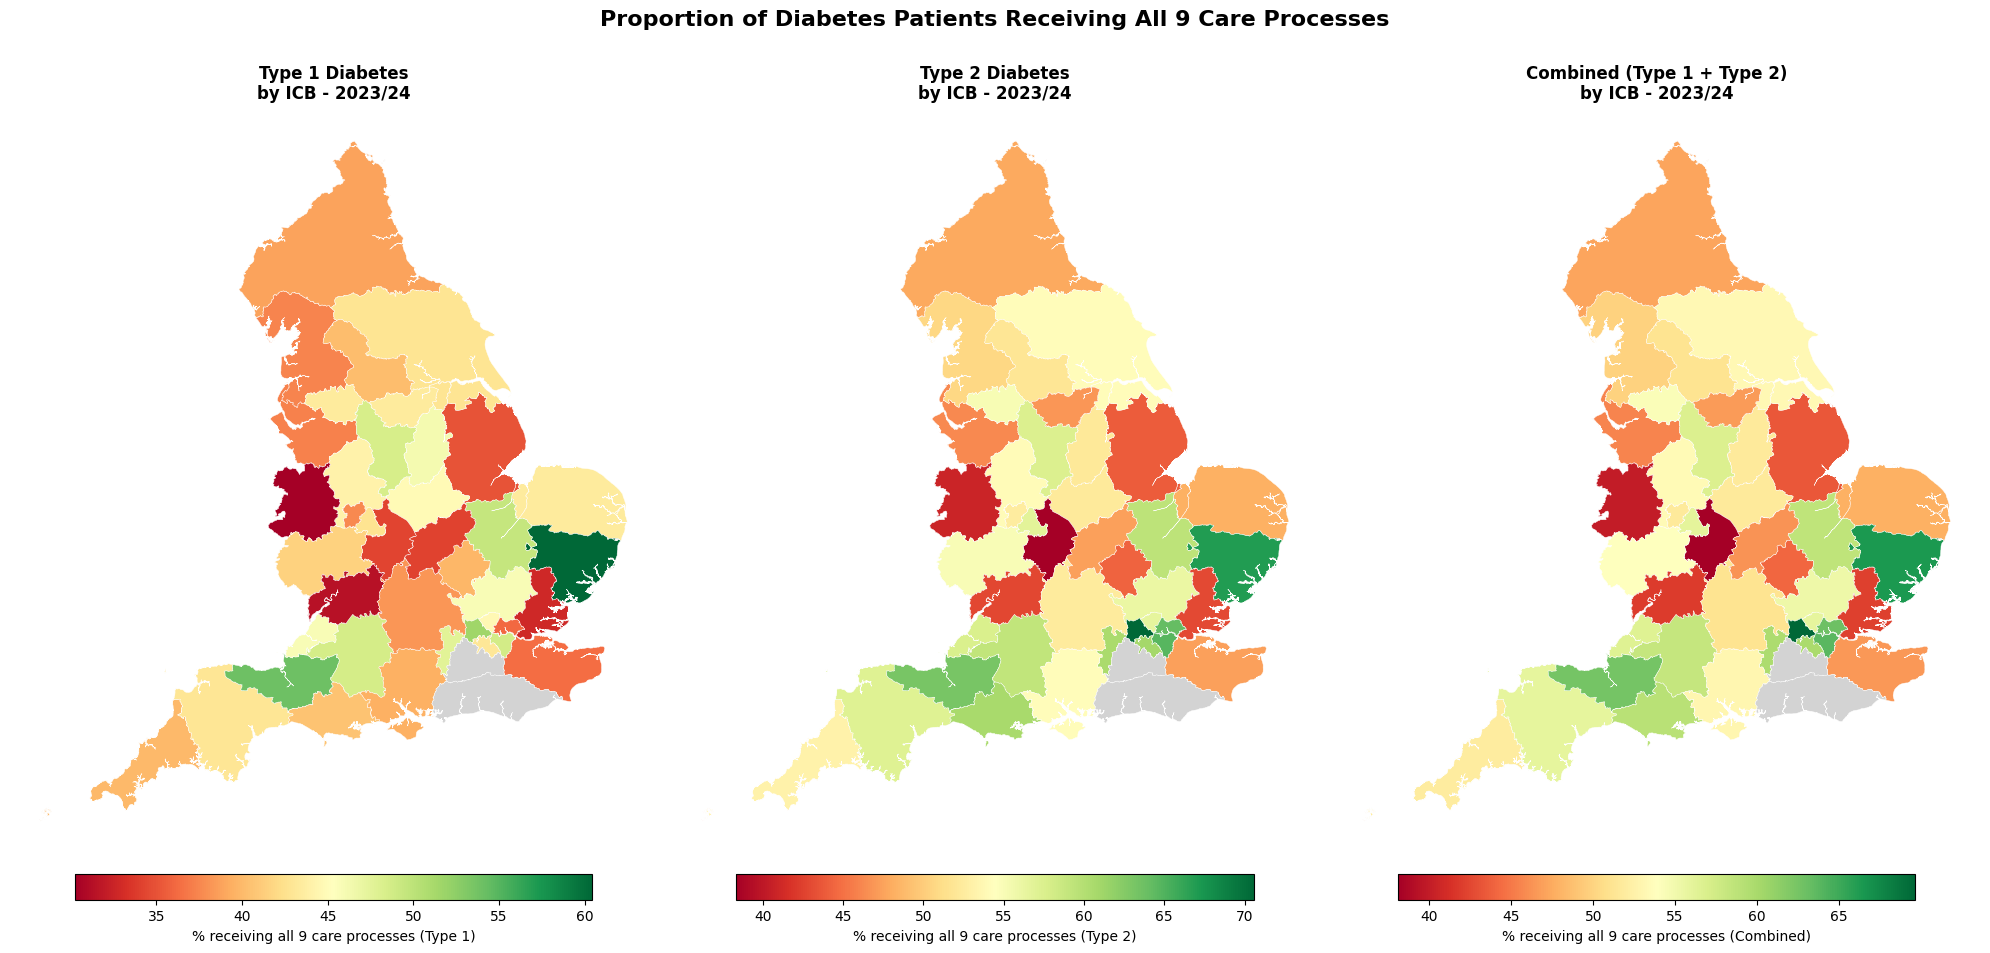


Summary Statistics:
Type                   Min       Mean        Max      Areas
------------------------------------------------------------
Type 1                30.2       42.1       60.4         40
Type 2                38.4       53.7       70.6         40
Combined              38.1       52.8       69.7         40


In [12]:
# Create all three maps using a loop: Type 1, Type 2, and Combined

# Prepare data for each map
map_configs = [
    {
        'data': df_t1_latest[['Area Code', 'Area Name', 'Value']],
        'value_col': 'Value',
        'title': 'Type 1 Diabetes',
        'label': '% receiving all 9 care processes (Type 1)'
    },
    {
        'data': df_t2_latest[['Area Code', 'Area Name', 'Value']],
        'value_col': 'Value',
        'title': 'Type 2 Diabetes',
        'label': '% receiving all 9 care processes (Type 2)'
    },
    {
        'data': df_combined[['Area Code', 'Area Name', 'Combined_Value']].rename(columns={'Combined_Value': 'Value'}),
        'value_col': 'Value',
        'title': 'Combined (Type 1 + Type 2)',
        'label': '% receiving all 9 care processes (Combined)'
    }
]

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for idx, config in enumerate(map_configs):
    # Merge with geographic boundaries
    gdf_plot = gdf.merge(
        config['data'],
        left_on='ICB23CD',
        right_on='Area Code',
        how='left'
    )
    
    # Plot map
    gdf_plot.plot(
        column=config['value_col'],
        ax=axes[idx],
        legend=True,
        legend_kwds={
            'label': config['label'],
            'orientation': 'horizontal',
            'shrink': 0.8,
            'pad': 0.02
        },
        cmap='RdYlGn',
        missing_kwds={'color': 'lightgrey', 'label': 'No data'},
        edgecolor='white',
        linewidth=0.3
    )
    
    axes[idx].set_title(f"{config['title']}\nby ICB - {latest_period}", fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Proportion of Diabetes Patients Receiving All 9 Care Processes', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics for all three
print("\nSummary Statistics:")
print("=" * 60)
print(f"{'Type':<15} {'Min':>10} {'Mean':>10} {'Max':>10} {'Areas':>10}")
print("-" * 60)
print(f"{'Type 1':<15} {df_combined['Value_T1'].min():>10.1f} {df_combined['Value_T1'].mean():>10.1f} {df_combined['Value_T1'].max():>10.1f} {df_combined['Value_T1'].notna().sum():>10}")
print(f"{'Type 2':<15} {df_combined['Value_T2'].min():>10.1f} {df_combined['Value_T2'].mean():>10.1f} {df_combined['Value_T2'].max():>10.1f} {df_combined['Value_T2'].notna().sum():>10}")
print(f"{'Combined':<15} {df_combined['Combined_Value'].min():>10.1f} {df_combined['Combined_Value'].mean():>10.1f} {df_combined['Combined_Value'].max():>10.1f} {df_combined['Combined_Value'].notna().sum():>10}")

### Identifying Best and Worst Performing Areas

Below we identify the **top 10** and **bottom 10** ICBs based on their combined diabetes care process completion rates. 

The number in brackets (n=X) shows the total number of diabetes patients in that ICB, giving context to the percentages - a small ICB with few patients may have more variable results than a large ICB.

In [13]:
# Top and bottom performing areas for combined diabetes
print("=" * 65)
print("TOP 10 AREAS - Highest % receiving all 9 care processes (Combined)")
print("=" * 65)
top_10_combined = df_combined.nlargest(10, 'Combined_Value')[['Area Name', 'Combined_Value', 'Total_Denominator']]
for _, row in top_10_combined.iterrows():
    print(f"{row['Area Name']}: {row['Combined_Value']:.1f}% (n={int(row['Total_Denominator']):,})")

print("\n" + "=" * 65)
print("BOTTOM 10 AREAS - Lowest % receiving all 9 care processes (Combined)")
print("=" * 65)
bottom_10_combined = df_combined.nsmallest(10, 'Combined_Value')[['Area Name', 'Combined_Value', 'Total_Denominator']]
for _, row in bottom_10_combined.iterrows():
    print(f"{row['Area Name']}: {row['Combined_Value']:.1f}% (n={int(row['Total_Denominator']):,})")

TOP 10 AREAS - Highest % receiving all 9 care processes (Combined)
NHS North West London Integrated Care Board - QRV: 69.7% (n=174,950)
NHS Suffolk and North East Essex Integrated Care Board - QJG: 66.4% (n=68,285)
NHS South East London Integrated Care Board - QKK: 63.8% (n=114,280)
NHS North East London Integrated Care Board - QMF: 62.9% (n=155,930)
NHS Somerset Integrated Care Board - QSL: 62.5% (n=39,035)
NHS South West London Integrated Care Board - QWE: 59.8% (n=85,580)
NHS Frimley Integrated Care Board - QNQ: 59.7% (n=49,255)
NHS Dorset Integrated Care Board - QVV: 59.0% (n=49,365)
NHS Cambridgeshire and Peterborough Integrated Care Board - QUE: 58.6% (n=57,130)
NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board - QOX: 58.3% (n=59,755)

BOTTOM 10 AREAS - Lowest % receiving all 9 care processes (Combined)
NHS Coventry and Warwickshire Integrated Care Board - QWU: 38.1% (n=65,495)
NHS Shropshire, Telford and Wrekin Integrated Care Board - QOC: 40.0% (n=33

---
## 5. Statistical Analysis: Does ICB Size Affect Care Quality?

### Research Question
Does the number of diabetes patients in an ICB (population size) correlate with care quality? 

**Hypothesis:** Larger ICBs might have more resources but also more complexity, while smaller ICBs might be more agile but resource-constrained.

### Method
We use **Pearson correlation** to test the relationship between:
- **X-axis**: Number of diabetes patients (denominator)
- **Y-axis**: Percentage receiving all 9 care processes (value)

A correlation coefficient (r) close to:
- **+1** = Strong positive relationship (more patients → better care)
- **-1** = Strong negative relationship (more patients → worse care)
- **0** = No relationship

The **p-value** tells us if the correlation is statistically significant (p < 0.05).

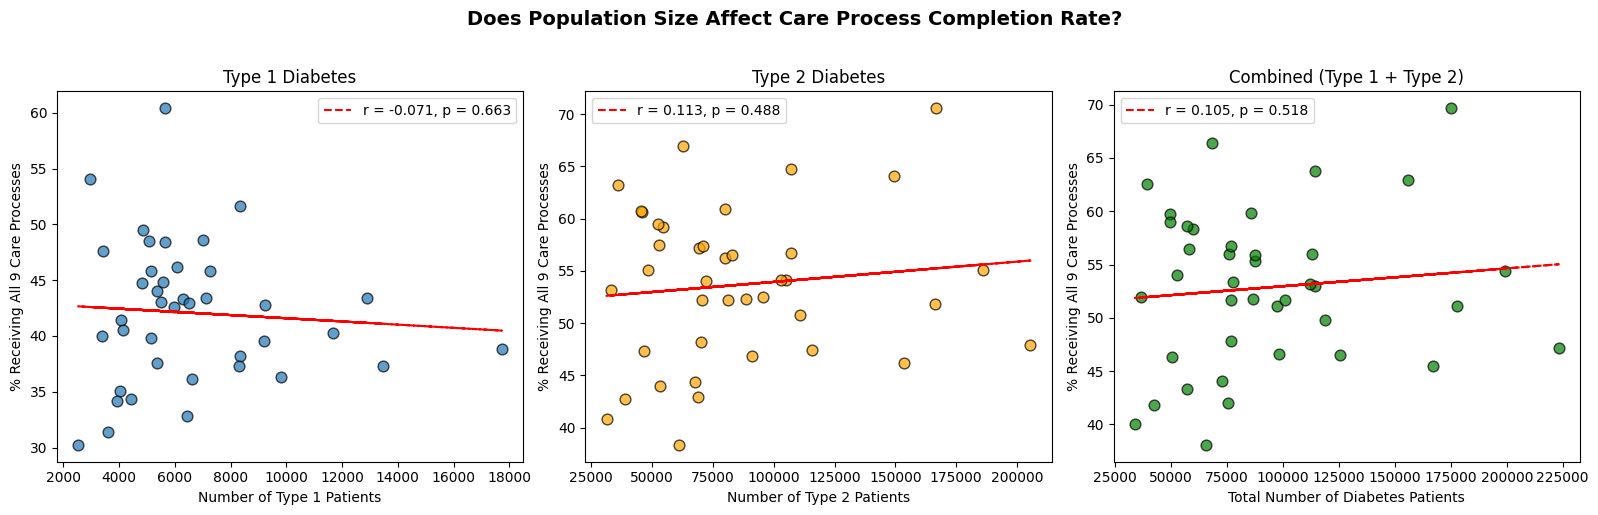


Correlation Summary:
Type 1:   r = -0.071, p = 0.663 
Type 2:   r = 0.113, p = 0.488 
Combined: r = 0.105, p = 0.518 

* indicates statistically significant correlation (p < 0.05)


In [14]:
# Analyse relationship between denominator (patient count) and value (% receiving care)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Type 1 Diabetes
ax1 = axes[0]
x1 = df_combined['Denominator_T1'].dropna()
y1 = df_combined.loc[x1.index, 'Value_T1']
ax1.scatter(x1, y1, alpha=0.7, edgecolor='black', s=60)
slope1, intercept1, r1, p1, se1 = stats.linregress(x1, y1)
ax1.plot(x1, slope1*x1 + intercept1, 'r--', label=f'r = {r1:.3f}, p = {p1:.3f}')
ax1.set_xlabel('Number of Type 1 Patients')
ax1.set_ylabel('% Receiving All 9 Care Processes')
ax1.set_title('Type 1 Diabetes')
ax1.legend()

# Plot 2: Type 2 Diabetes
ax2 = axes[1]
x2 = df_combined['Denominator_T2'].dropna()
y2 = df_combined.loc[x2.index, 'Value_T2']
ax2.scatter(x2, y2, alpha=0.7, edgecolor='black', s=60, color='orange')
slope2, intercept2, r2, p2, se2 = stats.linregress(x2, y2)
ax2.plot(x2, slope2*x2 + intercept2, 'r--', label=f'r = {r2:.3f}, p = {p2:.3f}')
ax2.set_xlabel('Number of Type 2 Patients')
ax2.set_ylabel('% Receiving All 9 Care Processes')
ax2.set_title('Type 2 Diabetes')
ax2.legend()

# Plot 3: Combined
ax3 = axes[2]
x3 = df_combined['Total_Denominator'].dropna()
y3 = df_combined.loc[x3.index, 'Combined_Value']
ax3.scatter(x3, y3, alpha=0.7, edgecolor='black', s=60, color='green')
slope3, intercept3, r3, p3, se3 = stats.linregress(x3, y3)
ax3.plot(x3, slope3*x3 + intercept3, 'r--', label=f'r = {r3:.3f}, p = {p3:.3f}')
ax3.set_xlabel('Total Number of Diabetes Patients')
ax3.set_ylabel('% Receiving All 9 Care Processes')
ax3.set_title('Combined (Type 1 + Type 2)')
ax3.legend()

plt.suptitle('Does Population Size Affect Care Process Completion Rate?', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print correlation summary
print("\nCorrelation Summary:")
print("=" * 50)
print(f"Type 1:   r = {r1:.3f}, p = {p1:.3f} {'*' if p1 < 0.05 else ''}")
print(f"Type 2:   r = {r2:.3f}, p = {p2:.3f} {'*' if p2 < 0.05 else ''}")
print(f"Combined: r = {r3:.3f}, p = {p3:.3f} {'*' if p3 < 0.05 else ''}")
print("\n* indicates statistically significant correlation (p < 0.05)")

---
## 6. Conclusions and Next Steps

### Key Findings

1. **Geographic Variation Exists**: There is significant variation in diabetes care quality across England, with completion rates ranging from ~38% to ~71%.

2. **Type 2 Has Higher Completion Rates**: On average, Type 2 diabetes patients have higher care process completion rates than Type 1 patients.

3. **Size Doesn't Matter**: ICB population size does not significantly predict care quality - both large and small ICBs can perform well or poorly.

### Implications for Policy
- Interventions should focus on **local factors** (workforce, funding, processes) rather than ICB size
- Best practices from high-performing ICBs could be shared with lower-performing areas
- Further investigation needed into why certain regions consistently underperform

### Limitations
- This analysis uses aggregate ICB-level data; GP-level analysis might reveal more granular patterns
- Cross-sectional data from a single time period; trends over time not examined
- Correlation analysis only - cannot establish causation

### Potential Next Steps
- Time series analysis to examine trends
- GP-level analysis for finer geographic resolution
- Regression analysis controlling for deprivation, demographics, and funding levels

### Interpretation: Population Size vs Care Quality

The correlation analysis shows **no statistically significant relationship** between ICB population size and care process completion rates:

| Diabetes Type | Correlation (r) | P-value | Significant? |
|---------------|-----------------|---------|--------------|
| Type 1        | -0.071          | 0.663   | No           |
| Type 2        | +0.113          | 0.488   | No           |
| Combined      | +0.105          | 0.518   | No           |

**Key findings:**
- All p-values are well above the 0.05 significance threshold
- Correlation coefficients are close to zero, indicating no linear relationship
- Care quality appears to be **independent of ICB size**

**What this means:**
The number of diabetes patients in an ICB does not predict whether that region will have higher or lower care process completion rates. Smaller and larger ICBs perform similarly on average. Variations in care rates are likely driven by other factors such as local policies, resource allocation, healthcare infrastructure, or workforce availability rather than population size alone.